[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
36/36 - 2s - 57ms/step - loss: 0.0810
Epoch 2/100
36/36 - 0s - 4ms/step - loss: 0.0477
Epoch 3/100
36/36 - 0s - 8ms/step - loss: 0.0391
Epoch 4/100
36/36 - 0s - 8ms/step - loss: 0.0363
Epoch 5/100
36/36 - 0s - 4ms/step - loss: 0.0350
Epoch 6/100
36/36 - 0s - 4ms/step - loss: 0.0343
Epoch 7/100
36/36 - 0s - 4ms/step - loss: 0.0340
Epoch 8/100
36/36 - 0s - 4ms/step - loss: 0.0338
Epoch 9/100
36/36 - 0s - 8ms/step - loss: 0.0338
Epoch 10/100
36/36 - 0s - 4ms/step - loss: 0.0336
Epoch 11/100
36/36 - 0s - 8ms/step - loss: 0.0337
Epoch 12/100
36/36 - 0s - 4ms/step - loss: 0.0335
Epoch 13/100
36/36 - 0s - 4ms/step - loss: 0.0338
Epoch 14/100
36/36 - 0s - 8ms/step - loss: 0.0338
Epoch 15/100
36/36 - 0s - 8ms/step - loss: 0.0336
Epoch 16/100
36/36 - 0s - 8ms/step - loss: 0.0336
Epoch 17/100
36/36 - 0s - 4ms/step - loss: 0.0336
Epoch 18/100
36/36 - 0s - 8ms/step - loss: 0.0335
Epoch 19/100
36/36 - 0s - 4ms/step - loss: 0.0336
Epoch 20/100
36/36 - 0s - 4ms/step - loss: 0.0335
Epoch 21

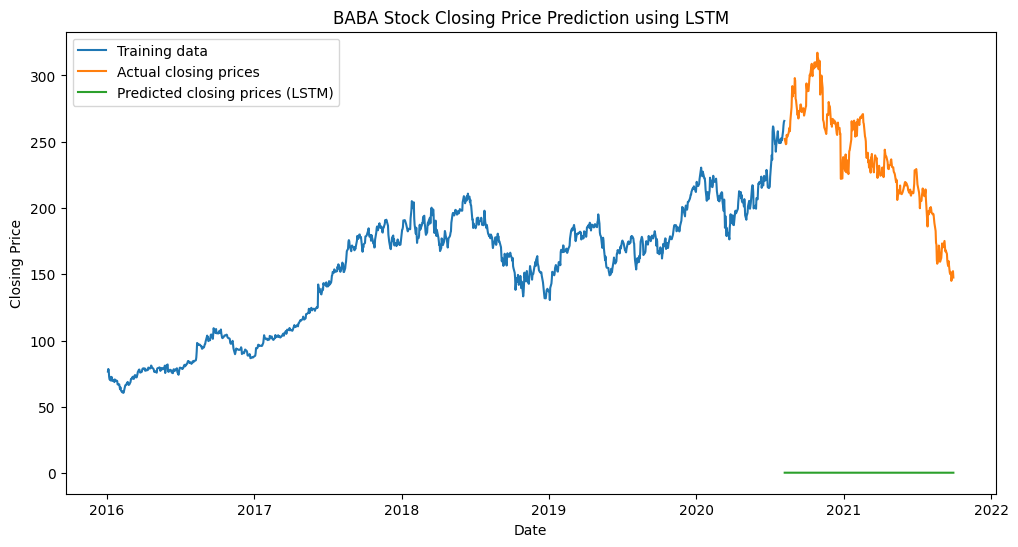

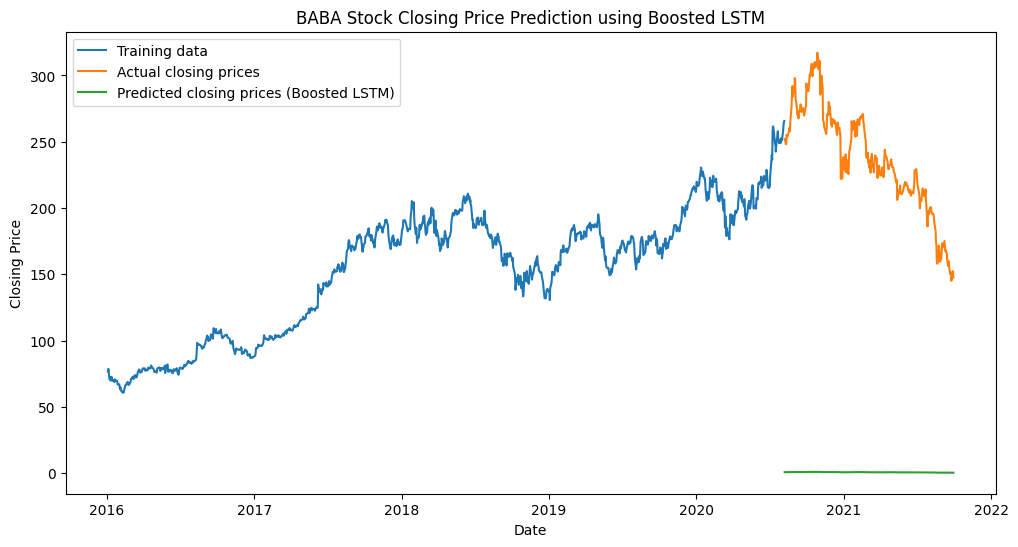

LSTM Model Metrics:
MSE: 0.1219
MAE: 0.3163
R2: -4.1150
Boosted LSTM Model Metrics:
MSE: 0.0001
MAE: 0.0050
R2: 0.9972


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, precision_score

# Download the dataset from yfinance
ticker = "BABA"
start_date = "2016-01-01"
end_date = "2021-10-01"
stock_data = yf.download(ticker, start=start_date, end=end_date)

# Normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_close = scaler.fit_transform(stock_data["Close"].values.reshape(-1, 1))

# Create a dataset with lagged values as features
def create_dataset(data, lag=1):
    X, y = [], []
    for i in range(len(data) - lag - 1):
        X.append(data[i:(i + lag), 0])
        y.append(data[i + lag, 0])
    return np.array(X), np.array(y)

lag = 5
X, y = create_dataset(scaled_close, lag)

# Reshape input to be [samples, timesteps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Split the data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Define the LSTM model
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the LSTM model
model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=2)

# Make predictions on the test set
y_pred_lstm = model.predict(X_test)
y_pred_lstm_2d = y_pred_lstm[:, -1, :]

# Boost the LSTM model using XGBoost
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
xgb_model.fit(y_pred_lstm_2d, y_test)

# Make predictions on the test set using the boosted model
y_pred_boosted = xgb_model.predict(y_pred_lstm_2d)

# Plot the actual vs. predicted closing prices before boosting
plt.figure(figsize=(12, 6))
plt.plot(stock_data["Close"].index[:train_size + lag], stock_data["Close"][:train_size + lag], label="Training data")
plt.plot(stock_data["Close"].index[train_size + lag:train_size + lag + len(y_pred_lstm_2d)], stock_data["Close"][train_size + lag:train_size + lag + len(y_pred_lstm_2d)], label="Actual closing prices")
plt.plot(stock_data["Close"].index[train_size + lag:train_size + lag + len(y_pred_lstm_2d)], y_pred_lstm_2d, label="Predicted closing prices (LSTM)")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.title("BABA Stock Closing Price Prediction using LSTM")
plt.legend()
plt.show()

# Plot the actual vs. predicted closing prices after boosting
plt.figure(figsize=(12, 6))
plt.plot(stock_data["Close"].index[:train_size + lag], stock_data["Close"][:train_size + lag], label="Training data")
plt.plot(stock_data["Close"].index[train_size + lag:train_size + lag + len(y_pred_boosted)], stock_data["Close"][train_size + lag:train_size + lag + len(y_pred_boosted)], label="Actual closing prices")
plt.plot(stock_data["Close"].index[train_size + lag:train_size + lag + len(y_pred_boosted)], y_pred_boosted, label="Predicted closing prices (Boosted LSTM)")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.title("BABA Stock Closing Price Prediction using Boosted LSTM")
plt.legend()
plt.show()

mse_lstm = mean_squared_error(y_test, y_pred_lstm_2d)
mae_lstm = mean_absolute_error(y_test, y_pred_lstm_2d)
r2_lstm = r2_score(y_test, y_pred_lstm_2d)

print("LSTM Model Metrics:")
print(f"MSE: {mse_lstm:.4f}")
print(f"MAE: {mae_lstm:.4f}")
print(f"R2: {r2_lstm:.4f}")

# Calculate metrics for boosted LSTM model
mse_boosted = mean_squared_error(y_test, y_pred_boosted)
mae_boosted = mean_absolute_error(y_test, y_pred_boosted)
r2_boosted = r2_score(y_test, y_pred_boosted)

print("Boosted LSTM Model Metrics:")
print(f"MSE: {mse_boosted:.4f}")
print(f"MAE: {mae_boosted:.4f}")
print(f"R2: {r2_boosted:.4f}")